In [1]:
# import packages

import pandas as pd
import numpy as np
import statistics
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, plot_precision_recall_curve
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [5]:
# import data

bank_data = pd.read_csv("BankChurners.csv").drop(columns = ['CLIENTNUM'])

bank_data = bank_data.replace('Unknown', np.nan)

# Transfer card category to integers, because there is a hierarical relationship
card_cate_map = {'Blue': 0, 'Silver': 1, 'Gold':2, 'Platinum': 3}
for i in range(len(bank_data['Card_Category'])):
    for j in card_cate_map:
        if bank_data['Card_Category'][i] == j:
            bank_data.at[i, 'Card_Category'] = card_cate_map[j]       

# Transfer education category to integers, because there is a hierarical relationship
education_cate_map = {'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4, 'Doctorate':5 }
for i in range(len(bank_data['Education_Level'])):
    for j in education_cate_map:
        if bank_data['Education_Level'][i] == j:
            bank_data.at[i, 'Education_Level'] = education_cate_map[j]

# Transfer income level category to integers, because there is a hierarical relationship
income_cate_map = { 'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K':3, '$120K +': 4}
for i in range(len(bank_data['Income_Category'])):
    for j in income_cate_map:
        if bank_data['Income_Category'][i] == j:
            bank_data.at[i, 'Income_Category'] = income_cate_map[j]

# Transfer attrition flag to zeros and ones, because it is the target and should be binary
attrition_flag_map = {'Existing Customer': 0, 'Attrited Customer': 1}
for i in range(len(bank_data['Attrition_Flag'])):
    for j in attrition_flag_map:
        if bank_data['Attrition_Flag'][i] == j:
            bank_data.at[i, 'Attrition_Flag'] = attrition_flag_map[j]
            
data_pd = pd.get_dummies(bank_data, columns = ['Gender','Marital_Status'])

data_names = data_pd.columns[1:]

### Encoding Method 1: Replacing Unknown Data with Mean Value

In [6]:
data1_pd = data_pd.fillna(data_pd.mean())

data1 = data1_pd.to_numpy()

### Encoding Method 2: Fixing Unknown Data Using Iterative Imputer

In [7]:
data2_np = data_pd.to_numpy()

imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data2_np)
IterativeImputer(random_state=0)
data2 = imp_mean.transform(data2_np)

array_sum = np.sum(data2)
array_has_nan = np.isnan(array_sum)
array_has_nan

False

### Data Proprocessing

In [8]:
# Split the target column and features
X1 = data1[:, 1:]
y1 = data1[:, 0]

X2 = data2[:, 1:]
y2 = data2[:, 0]

In [ ]:
# Use LabelEncoder to transform target values into integers.
label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(y1)
y2 = label_encoder.fit_transform(y2)

In [9]:
# Preprocess the data with the StandardScalar
sc_X = StandardScaler()
X1 = sc_X.fit_transform(X1)
X2 = sc_X.fit_transform(X2)

In [10]:
# Removes highly correlated data
X1 = pd.DataFrame(X1)
cor_matrix1 = X1.corr().abs()
# Select upper triangle of correlation matrix
upper_tri1 = cor_matrix1.where(np.triu(np.ones(cor_matrix1.shape),k=1).astype(bool))
to_drop1 = [column for column in upper_tri1.columns if any(upper_tri1[column] > 0.90)]
print("There are " + str(len(to_drop1)) + " columns to be dropped in the first preprocessing dataset")
X1 = X1.drop(X1.columns[to_drop1], axis = 1)
feature_mapping1 = []
for i in range(len(data_names)):
    if i not in to_drop1:
        feature_mapping1.append(data_names[i])

# Removes highly correlated data
X2 = pd.DataFrame(X2)
cor_matrix2 = X2.corr().abs()
# Select upper triangle of correlation matrix
upper_tri2 = cor_matrix2.where(np.triu(np.ones(cor_matrix2.shape),k=1).astype(bool))
to_drop2 = [column for column in upper_tri2.columns if any(upper_tri2[column] > 0.90)]
print("There are " + str(len(to_drop2)) + " columns to be dropped in the second preprocessing dataset")
X2 = X2.drop(X2.columns[to_drop2], axis = 1)
feature_mapping2 = []
for i in range(len(data_names)):
    if i not in to_drop2:
        feature_mapping2.append(data_names[i])

There are 2 columns to be dropped in the first preprocessing dataset
There are 2 columns to be dropped in the second preprocessing dataset


### Set the Encoding Method

In [11]:
X = X1
y = y1
feature_mapping = feature_mapping1

### Calculate feature importance

In [31]:
feature_dict={}
    
def feature_importance(name, model):
    """calculates the feature importance under each model and adds them to the dictionary"""
    model.fit(X, y)
    temp_dict={}
    if name == "SVM Linear":
        importance = [abs(model.coef_[0][i]) for i in range(len(model.coef_[0]))]
    else:
        importance = model.feature_importances_
    for i,v in enumerate(importance):
        temp_dict[feature_mapping[i]] = v
        feature_dict[name] = temp_dict
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

def high_low_feature(feature_dict, name):
    """selects the most importance feature under a specific model"""
    max_key = max(feature_dict[name], key=feature_dict[name].get)
    max_value = max(feature_dict[name].values())
    print("The most important feature is", max_key, "with the importance of", max_value)
    print()

The model running is: xgboost


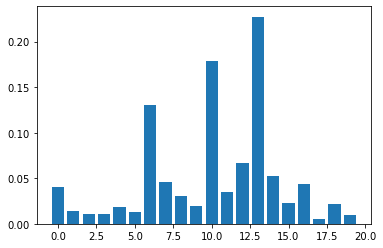

The most important feature is Total_Trans_Ct with the importance of 0.22733772

The average score is 0.9712649141408601 with std of 0.002747320117628411

The area under the precision-recall curve is 0.9701932020224411

The average score is 0.9722527147087858 with std of 0.004363649339465015

The area under the precision-recall curve is 0.9712781522157189

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8500
           1       0.94      0.89      0.91      1627

    accuracy                           0.97     10127
   macro avg       0.96      0.94      0.95     10127
weighted avg       0.97      0.97      0.97     10127

                 Predicted Negative  Predicted Positive
Actual Negative                8403                  97
Actual Positive                 181                1446

The FN is 181
The tn is 8403
The tp is 1446
The fp is 97

The precision is: 0.9371354504212573
The recall is: 0.8887523048555623
The f1 score is: 

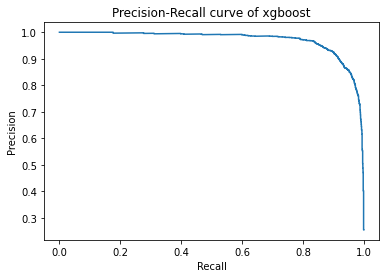

In [36]:
scoring = "accuracy"
number_repeat = 2 #minimum is 1
score_dict = {}
auc_dict = {}

# define models to train
names = ['xgboost',
#         'Decision Tree',
#          'SVM Linear',
#          'SVM RBF', 
#          'SVM Sigmoid'
#          'BaggingClassifier',
#          'RandomForest',
#          'Adaboost'
        ]

# build classifiers
classifiers = [xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss', random_state=42, use_label_encoder=False),
#                tree.DecisionTreeClassifier(),
#                SVC(kernel='linear', C = 2.0, gamma='scale'),
#                SVC(kernel='rbf', C = 2.0, gamma='scale'),
#                SVC(kernel='sigmoid', C = 2.0, gamma='scale'),
#                BaggingClassifier(n_estimators=200, oob_score = True),
#                RandomForestClassifier(n_estimators=300, max_features = "sqrt", oob_score = True),
#                AdaBoostClassifier(n_estimators=400, learning_rate = 0.6),
              ]

models = zip(names, classifiers)

for name, model in models:
    # Use stratified k-fold cross validation to deal with imbalanced data
    print("The model running is: " + name)
    if name != "BaggingClassifier":
        feature_importance(name, model)
    high_low_feature(feature_dict, name)
    for i in range(number_repeat):
        kfold = StratifiedKFold(n_splits=5, shuffle=True)
        scores = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        if name not in score_dict:
            score_dict[name] = [] 
        score_dict[name].append((scores.mean(), scores.std()))
        print("The average score is", scores.mean(), "with std of", scores.std())
        print()
        y_pred = cross_val_predict(model, X, y, cv=kfold, method='predict_proba')[:, 1]
        if name not in auc_dict:
            auc_dict[name] = [] 
        precision, recall, thresholds = precision_recall_curve(y, y_pred)
        auc_precision_recall = auc(recall, precision)
        auc_dict[name].append(auc_precision_recall)
        print("The area under the precision-recall curve is", auc_precision_recall)
        print()
    
    # visualize the model result
    y_classification = cross_val_predict(model, X, y, cv=kfold)
    y_pred = cross_val_predict(model, X, y, cv=kfold,method='predict_proba')[:, 1]
    print(classification_report(y, y_classification))

    confusion_mat = confusion_matrix(y, y_classification)
    graph = pd.DataFrame(confusion_mat,
                         columns=['Predicted Negative', 'Predicted Positive'],
                         index=['Actual Negative', 'Actual Positive'])
    print(graph)
    print()
    
    fn = confusion_mat[1][0]
    tn = confusion_mat[0][0]
    tp = confusion_mat[1][1]
    fp = confusion_mat[0][1] 

    print("The FN is", fn)
    print("The tn is", tn)
    print("The tp is", tp)
    print("The fp is", fp)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall / (precision + recall))

    print()
    print("The precision is:", precision)
    print("The recall is:", recall)
    print("The f1 score is:", f1_score)
    print()

    print("The area under the Receiver Operating Characteristic curve is:", str(roc_auc_score(y, y_classification)))
    print()
    
    auc_precision_recall_mean = sum(auc_dict[name]) / len(auc_dict[name])
    auc_precision_recall_std = statistics.pstdev(auc_dict[name])
    print("The averagve area under the precision-recall curve is", auc_precision_recall_mean, "with std of", auc_precision_recall_std)
    print()
    
    temp_list = score_dict[name]
    score_mean = 0
    score_std = 0
    for i in temp_list:
        score_mean += i[0]
        score_std += i[1]
    score_mean /= len(temp_list)
    score_std /= len(temp_list)
    print("The average accuracy is", score_mean, "with the std of", score_std)
    print()
    
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    plt.plot(recall, precision)
    plt.title("Precision-Recall curve of " + name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()